<img src="images/tennisballbounce1.jpg" alt="Drawing" style="width: 360px;"/><img src="images/rafashot.jpg" alt="Drawing" style="width: 295px;"/>

## ATP Match Study: Inference Analysis

In this notebook, we're looking at the statistical significance of distribution differences between match statistics of winners versus losers (non-winners). This is not testing all of the match statistics; only those that seemed relevant for the model built in the EDA notebook.

In [1]:
import pandas as pd

# Import Data
train = pd.read_csv('data/results.csv').set_index(['match_id'])
train = train.drop(['Unnamed: 0'], axis = 1)
wins = train.loc[train.win == True,:].copy()
nowins = train.loc[train.win == False,:].copy()

In [2]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Random
np.random.seed(500)

# Set default for figure sizes
mlp.rcParams['figure.figsize'] = (16,6)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

In [3]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
match_duration,176412.0,99.976646,37.412780,30.000000,73.000000,93.000000,121.000000,353.000000
rank_dif,176412.0,0.000000,202.020267,-2126.000000,-49.000000,0.000000,49.000000,2126.000000
year,176412.0,2004.223012,7.684767,1990.000000,1997.000000,2005.000000,2011.000000,2016.000000
month,176412.0,5.662925,2.985378,1.000000,3.000000,6.000000,8.000000,12.000000
day,176412.0,16.041573,8.550998,1.000000,9.000000,16.000000,24.000000,31.000000
aces,176412.0,5.426394,4.830283,0.000000,2.000000,4.000000,7.000000,61.000000
double_faults,176412.0,3.120683,2.502078,0.000000,1.000000,3.000000,4.000000,26.000000
first_serves_in,176412.0,46.269948,19.410373,0.000000,33.000000,43.000000,57.000000,196.000000
first_serves_total,176412.0,78.520543,28.215650,22.000000,57.000000,73.000000,94.000000,273.000000
first_serve_points_won,176412.0,33.218432,13.643152,1.000000,24.000000,31.000000,40.000000,148.000000


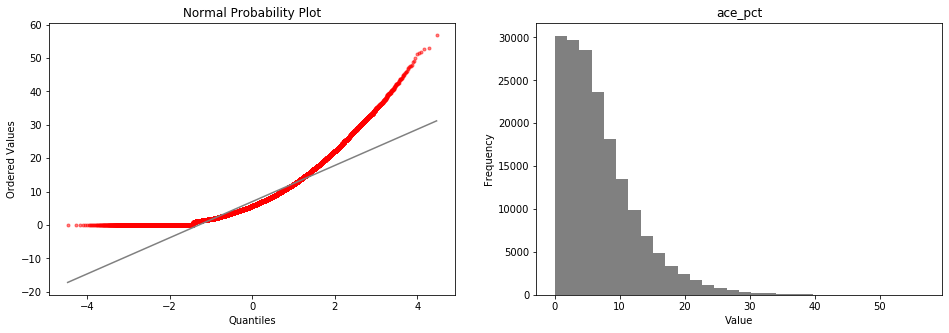

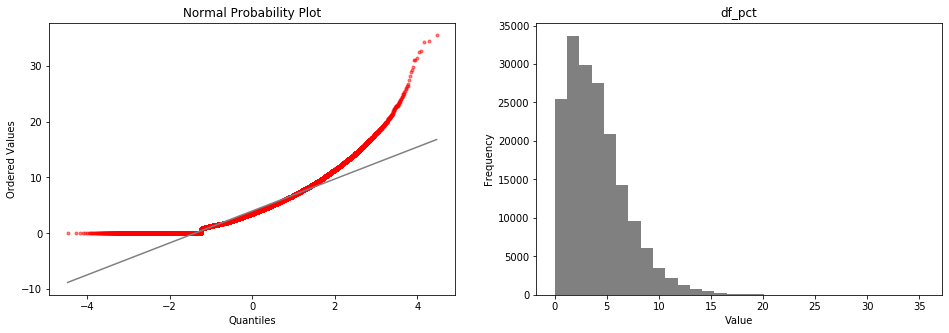

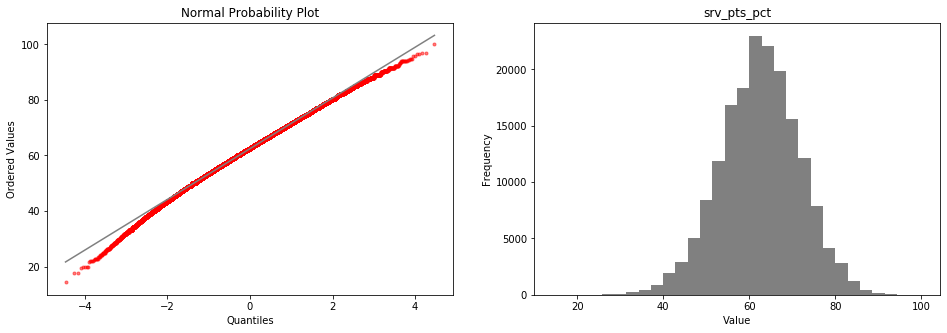

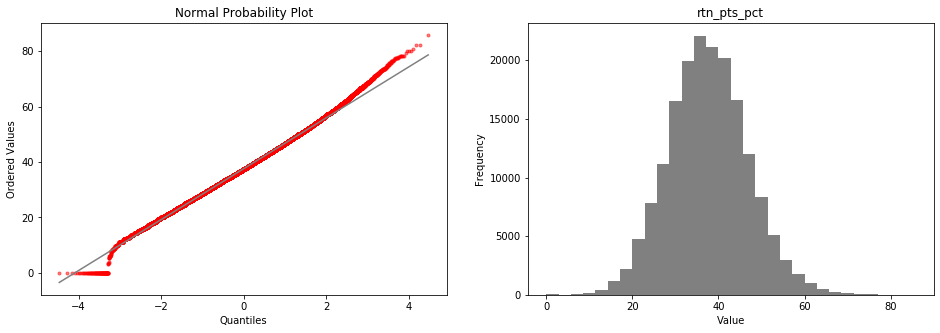

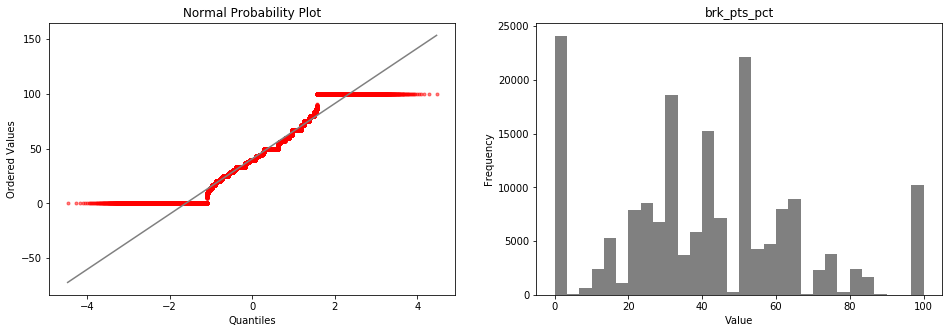

In [4]:
import scipy.stats as stats

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)
    _ = plt.xlabel('Value')
    _ = plt.ylabel('Frequency')

features = ['ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct','rank_number']
no_discrete_ft = ['ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct']

for feature in no_discrete_ft:
    qq_plot(train[feature])
    plt.title(feature)

## Total Points Won Percent Distribution

Wins Mean: 55.467522564258786
No-Wins Mean: 44.53247743574097
Mean Diff: 10.935045128517814
H0 Diff: 0


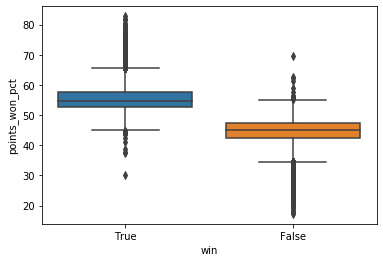

p: 0.0
CI: [-0.06473506  0.0630928 ]
ME: 0.06335940191360641


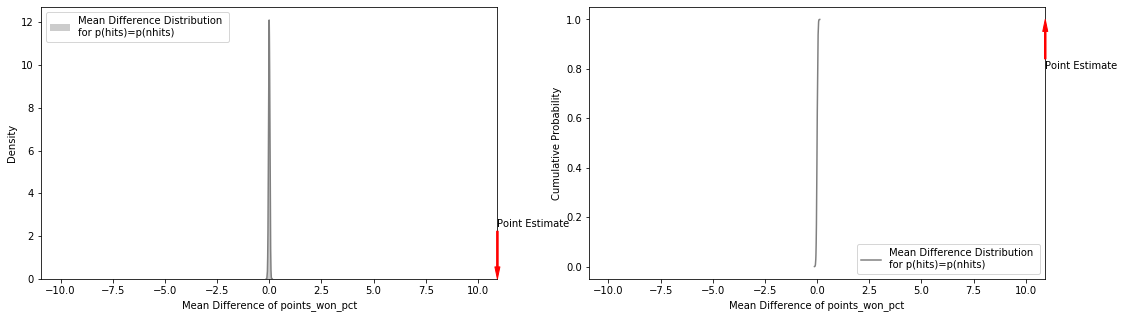

In [6]:
wins_totalpointswonpercent = wins.points_won_pct.dropna()
nowins_totalpointswonpercent = nowins.points_won_pct.dropna()

wins_nowins_diff = wins_totalpointswonpercent.mean() - nowins_totalpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.points_won_pct.mean(), nowins.points_won_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='points_won_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_totalpointswonpercent,nowins_totalpointswonpercent,wins_nowins_diff)

## Ace Percent Distribution

Wins Mean: 8.340683934072723
No-Wins Mean: 5.599402213071454
Mean Diff: 2.741281721001269
H0 Diff: 0


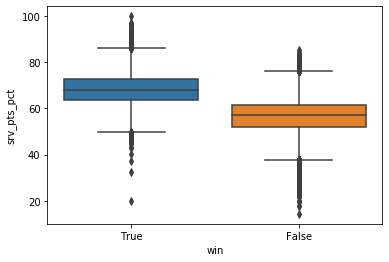

p: 0.0
CI: [-0.05420881  0.05300358]
ME: 0.05281356846025583


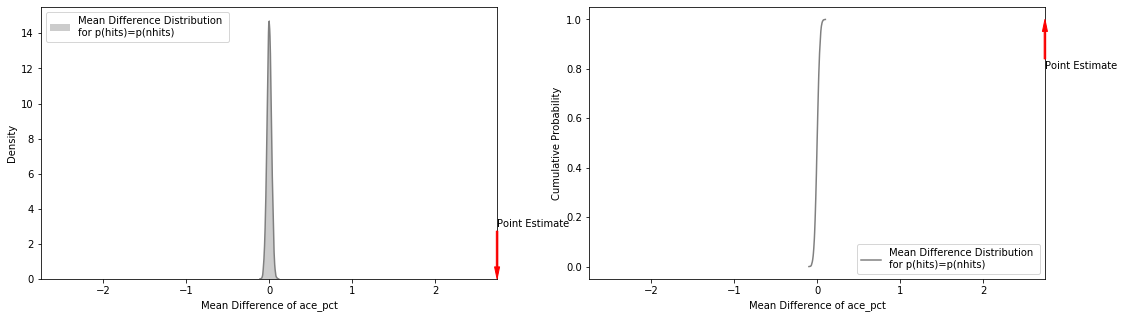

In [9]:
wins_acepercent = wins.ace_pct.dropna()
nowins_acepercent = nowins.ace_pct.dropna()

wins_nowins_diff = wins_acepercent.mean() - nowins_acepercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.ace_pct.mean(), nowins.ace_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='srv_pts_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_acepercent,nowins_acepercent,wins_nowins_diff)

## Double Faults Distribution

Wins Mean: 3.471326834959865
No-Wins Mean: 4.511129954525473
Mean Diff: 11.528019211812783
H0 Diff: 0


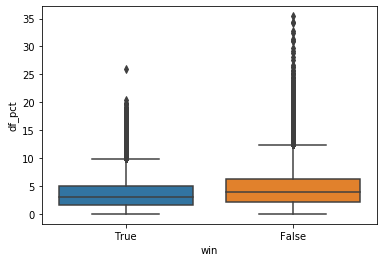

p: 0.0
CI: [-0.08503981  0.08462174]
ME: 0.08422264491354459


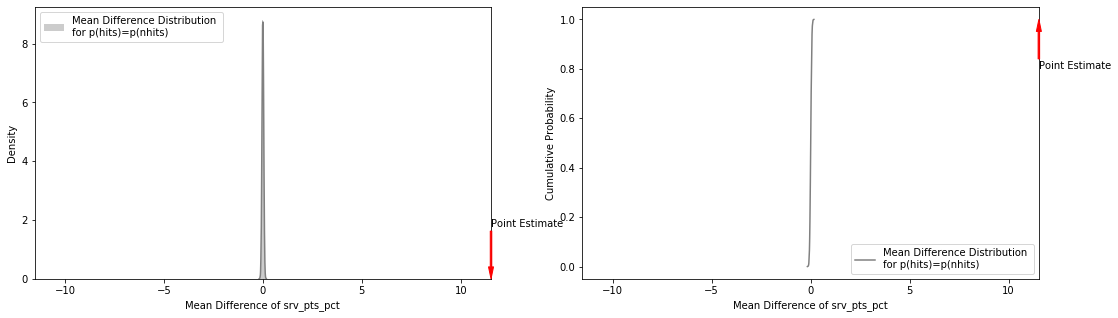

In [10]:
wins_doublefaultspercent = wins.srv_pts_pct.dropna()
nowins_doublefaultspercent = nowins.srv_pts_pct.dropna()

wins_nowins_diff = wins_doublefaultspercent.mean() - nowins_doublefaultspercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.df_pct.mean(), nowins.df_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='df_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_doublefaultspercent,nowins_doublefaultspercent,wins_nowins_diff)

## Serve Points Won Distribution

Wins Mean: 68.22250043301648
No-Wins Mean: 56.694481221203695
Mean Diff: 11.528019211812783
H0 Diff: 0


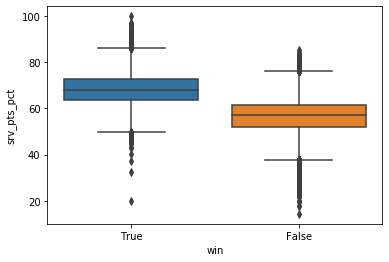

p: 0.0
CI: [-0.08455944  0.08522842]
ME: 0.0850412005235395


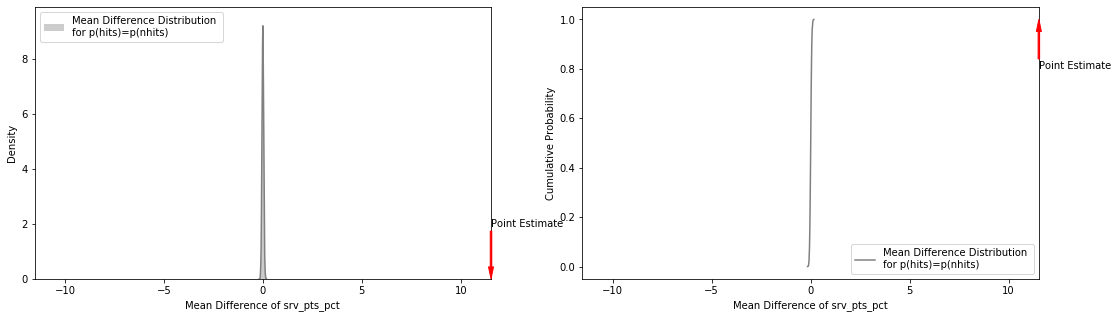

In [7]:
wins_servepointswonpercent = wins.srv_pts_pct.dropna()
nowins_servepointswonpercent = nowins.srv_pts_pct.dropna()

wins_nowins_diff = wins_servepointswonpercent.mean() - nowins_servepointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.srv_pts_pct.mean(), nowins.srv_pts_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='srv_pts_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_servepointswonpercent,nowins_servepointswonpercent,wins_nowins_diff)

## Return Points Won Percent Distribution

Wins Mean: 43.3193882825373
No-Wins Mean: 31.80259127897296
Mean Diff: 11.516797003564335
H0 Diff: 0


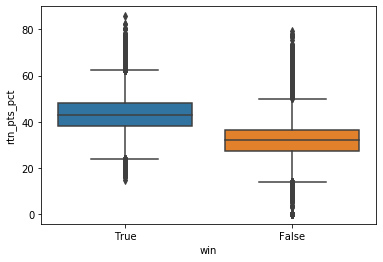

p: 0.0
CI: [-0.08644826  0.08607465]
ME: 0.08605680308714214


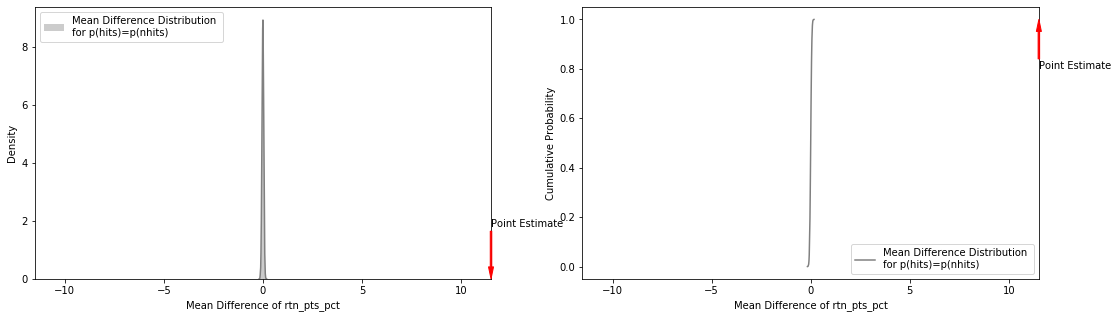

In [11]:
wins_returnpointswonpercent = wins.rtn_pts_pct.dropna()
nowins_returnpointswonpercent = nowins.rtn_pts_pct.dropna()

wins_nowins_diff = wins_returnpointswonpercent.mean() - nowins_returnpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.rtn_pts_pct.mean(), nowins.rtn_pts_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='rtn_pts_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_returnpointswonpercent,nowins_returnpointswonpercent,wins_nowins_diff)

## Break Points Won Percent Distribution

Wins Mean: 49.53499443350504
No-Wins Mean: 31.58515297066974
Mean Diff: 17.949841462835302
H0 Diff: 0


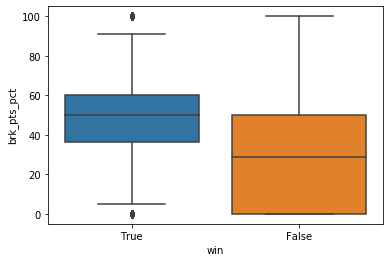

p: 0.0
CI: [-0.24274992  0.23574674]
ME: 0.2369419872668727


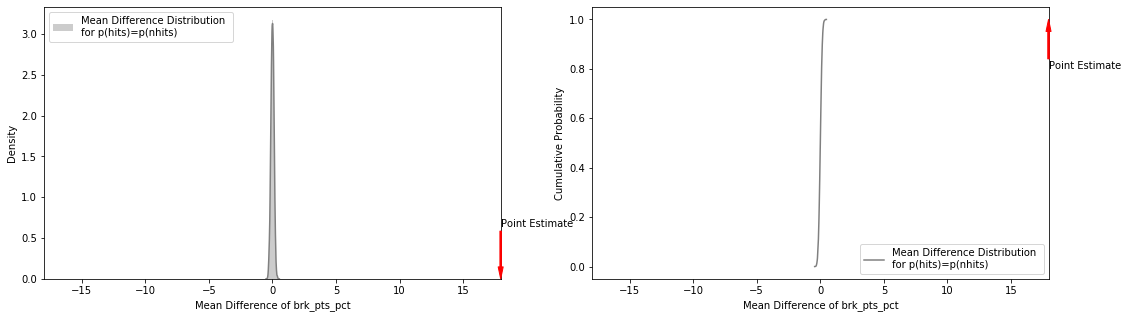

In [12]:
wins_breakpointswonpercent = wins.brk_pts_pct.dropna()
nowins_breakpointswonpercent = nowins.brk_pts_pct.dropna()

wins_nowins_diff = wins_breakpointswonpercent.mean() - nowins_breakpointswonpercent.mean()
h0_diff = 0
print("Wins Mean: {}\nNo-Wins Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.brk_pts_pct.mean(), nowins.brk_pts_pct.mean(), wins_nowins_diff,h0_diff))

sns.boxplot(x='win',y='brk_pts_pct',data=train,order=[True,False])
plt.show()

test_mean_diff(wins_breakpointswonpercent,nowins_breakpointswonpercent,wins_nowins_diff)